# Wzbogacenie cech użytkowników

In [83]:
%load_ext autoreload
%autoreload 2

In [8]:
from node2vec import Node2Vec
from gensim.models import Word2Vec
from pathlib import Path

import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP

import networkx as nx
import matplotlib.pyplot as plt

ImportError: cannot import name 'UMAP' from 'umap' (/home/oliwier/.local/share/virtualenvs/representation-project-OwX4NmtW/lib/python3.10/site-packages/umap/__init__.py)

In [ ]:
!pip install umap-learn

In [86]:
EMBBEDDINGS_PATH = Path("embbeddings")
DATA_PATH = Path("data")
IMAGES_PATH = Path("images")

In [94]:
user_info_df = pd.read_csv(DATA_PATH / "labels_undirected.tsv", sep=" ").sort_values(by="user_id")
user_info_df

,user_id,department_id
0,0,1
1,1,1
2,2,21
3,3,21
4,4,21
...,...,...
981,1000,4
982,1001,21
983,1002,1
984,1003,6


## Tworzenie nowych reprezentacji

In [9]:
G = nx.read_gpickle(DATA_PATH / 'network.gpickle')

In [ ]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4) 

In [ ]:
model.wv.save_word2vec_format(str(EMBBEDDINGS_PATH / "embbeddings.graphvectors"))
model.save(str(EMBBEDDINGS_PATH / "graph.model"))

## Wczytanie przygotowanych reprezentacji

In [27]:
model = Word2Vec.load(str(EMBBEDDINGS_PATH / "graph.model"))

In [28]:
model.wv[985]  # load embbedding

array([-0.12819892,  0.40796456, -0.23906405,  0.04626611, -0.3090854 ,
       -0.54391235, -0.2935991 ,  0.19762456,  0.7819692 , -0.05865564,
        0.3504137 , -0.6531082 , -0.26727948,  0.07874596,  0.3772808 ,
        0.37962884, -0.19650452, -0.9063179 , -0.34588027,  0.19844303,
       -0.00430199,  0.27667487,  0.15289463, -0.23950194, -0.20911737,
        0.10903276,  0.05966701,  0.15530281,  0.07285277,  0.23411253,
       -0.00492517, -0.26225814,  0.0111703 ,  0.18395276,  0.18952058,
        0.09655321,  0.58138454, -0.15614112,  0.40844518,  0.3978298 ,
        0.05625967,  0.55434084, -0.14211927, -0.04689564, -0.33468652,
       -0.3309656 , -0.06554087,  0.3766096 ,  0.16667865, -0.45705634,
        0.43596584, -0.29748732,  0.20267041, -0.3851369 ,  0.45026663,
        0.23562913, -0.23787594, -0.04058339, -0.37557977, -0.17209442,
       -0.06682142,  0.33547625,  0.17945936,  0.29270235], dtype=float32)

## Analiza wygenerowanych embbedingów

In [68]:
def concat_embbeddings(model: Word2Vec):
    embbedings = []
    for i in range(len(model.wv.key_to_index)):
        result = model.wv[i]
        embbedings.append(result.reshape((1, result.shape[0])))
    return np.concatenate(embbedings, axis=0)

In [69]:
full_embbedings = concat_embbeddings(model)
full_embbedings.shape

(986, 64)

In [108]:
colors = [user_info_df[user_info_df["user_id"] == int(id_)]["department_id"].iloc[0] for id_ in model.wv.key_to_index.keys()]
len(colors)

986

In [ ]:
z_PCA = PCA(n_components=2).fit_transform(full_embbedings)
z_UMAP = UMAP(n_components=2).fit_transform(full_embbedings)

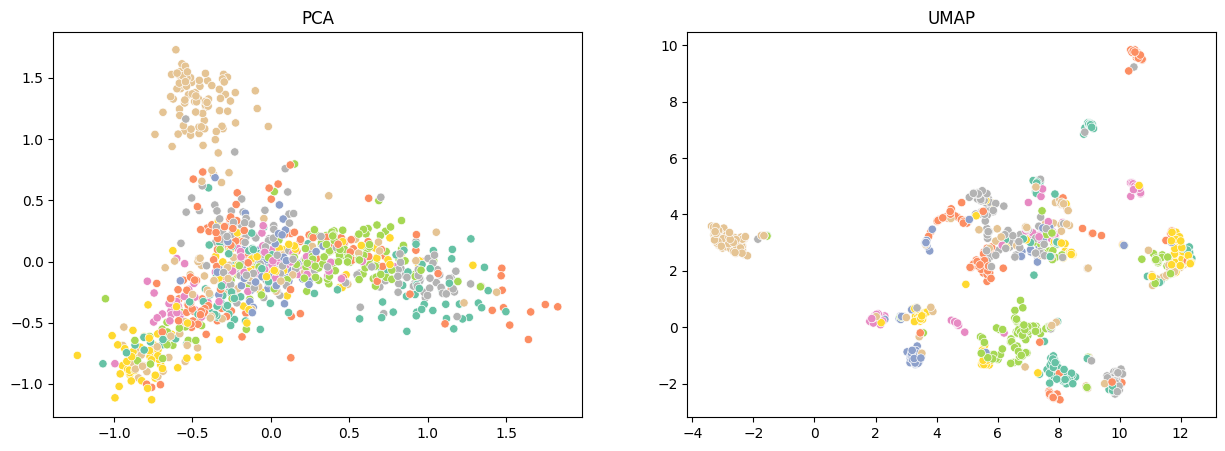

In [109]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.scatterplot(x=z_PCA[:, 0], y=z_PCA[:, 1], hue=colors, palette="Set2", ax=axs[0])
axs[0].set(title="PCA")
axs[0].get_legend().remove()
sns.scatterplot(x=z_UMAP[:, 0], y=z_UMAP[:, 1], hue=colors, palette="Set2", ax=axs[1])
axs[1].set(title="UMAP")
axs[1].get_legend().remove()
fig.savefig(IMAGES_PATH / "basic_representation.png")

## Zapisanie wygenerowanych embbeddingów

In [92]:
def save_embbeddings_info(df: pd.DataFrame, index_map: dict):
    values = []
    for id_ in list(df.user_id):
        values.append(index_map[str(id_)])
    df["embbedding_id"] = values
    return df

In [111]:
user_info_df = save_embbeddings_info(user_info_df, model.wv.key_to_index)
user_info_df

,user_id,department_id,embbedding_id
0,0,1,266
1,1,1,215
2,2,21,60
3,3,21,128
4,4,21,63
...,...,...,...
981,1000,4,759
982,1001,21,674
983,1002,1,924
984,1003,6,974


In [112]:
user_info_df.to_csv(DATA_PATH / "train_data.tsv", sep=" ", index=False)